In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 328 (delta 114), reused 108 (delta 85), pack-reused 162
Receiving objects: 100% (328/328), 234.56 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [ ]:
cd /content/lag-llama

/content/lag-llama


In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 894.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not current

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 55.7MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-6-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device = torch.device('cpu'),
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

In [ ]:
0.8593


     Week  Cases  Rainfall                 date
0       1      0       0.0  01-01-2014 00:00:00
1       2      4       0.0  01-08-2014 00:00:00
2       3      0       0.0  01-15-2014 00:00:00
3       4      1       0.0  01-22-2014 00:00:00
4       5      2       0.0  01-29-2014 00:00:00
..    ...    ...       ...                  ...
419   420     11       0.0  01-12-2022 00:00:00
420   421      4       0.0  01-19-2022 00:00:00
421   422      3       0.0  01-26-2022 00:00:00
422   423      9       0.0  02-02-2022 00:00:00
423   424      2       0.0  02-09-2022 00:00:00

[424 rows x 4 columns]


In [ ]:
df = df.drop('Week',axis=1)
df = df.drop('Rainfall',axis=1)
print(df)

     Cases                 date
0        0  01-01-2014 00:00:00
1        4  01-08-2014 00:00:00
2        0  01-15-2014 00:00:00
3        1  01-22-2014 00:00:00
4        2  01-29-2014 00:00:00
..     ...                  ...
419     11  01-12-2022 00:00:00
420      4  01-19-2022 00:00:00
421      3  01-26-2022 00:00:00
422      9  02-02-2022 00:00:00
423      2  02-09-2022 00:00:00

[424 rows x 2 columns]


In [ ]:
df = df.set_index('date')
df.head(10)

,Cases
date,
01-01-2014 00:00:00,0
01-08-2014 00:00:00,4
01-15-2014 00:00:00,0
01-22-2014 00:00:00,1
01-29-2014 00:00:00,2
02-05-2014 00:00:00,0
02-12-2014 00:00:00,1
02-19-2014 00:00:00,2
02-26-2014 00:00:00,0


In [ ]:
df_train = df.iloc[:-58]
df_test = df.iloc[-58:-6]

In [ ]:
df_train.shape

(366, 1)

In [ ]:
from gluonts.dataset.common import ListDataset

# Assuming 'total' is the target time series
training_data = ListDataset(
    [{"start": df_train.index[0], "target": df_train["Cases"].values}],
    freq="W"  # Assuming weekly frequency; adjust as needed
)

In [ ]:
from gluonts.dataset.common import ListDataset

# Assuming 'total' is the target time series
testing_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test["Cases"].values}],
    freq="W"  # Assuming weekly frequency; adjust as needed
)

In [ ]:
print(training_data)

[{'start': Period('2013-12-30/2014-01-05', 'W-SUN'), 'target': array([ 0.,  4.,  0.,  1.,  2.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,
        0.,  1.,  4., 16., 19., 17., 15., 12., 15., 11., 19., 20., 20.,
       22., 33., 18., 32., 22., 17., 28., 34., 42., 22., 16., 11., 15.,
        5.,  4.,  1.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  3.,  2.,  6.,  1.,  2.,  0.,  1.,  2.,  7.,  2.,  2.,
        2.,  1.,  3.,  1.,  4., 10., 10.,  8., 11., 15., 26., 20., 19.,
       22., 10., 13., 11.,  1.,  8.,  4.,  1.,  5.,  5.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  3.,  2.,  3.,  2.,  1.,  1.,  3.,  3.,  6.,
        6.,  7., 12.,  5.,  7.,  5.,  2.,  1.,  6.,  2.,  0.,  3.,  2.,
        4.,  3.,  5.,  4.,  9., 16.,  7.,  9.,  4.,  8.,  6.,  9.,  8.,
        5., 16., 15., 13., 17., 23., 15., 14., 16., 20., 11., 14., 16.,
        9.,  8.,  0.,  4.,  4.,  1.,  3.,  3.,  2.,  2.,  2.,  2.,  3.,
 

In [ ]:
prediction_length = 10
context_length = prediction_length*3
num_samples = 20
device = "cpu"

In [ ]:
forecasts, tss = get_lag_llama_predictions(
    testing_data,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1 [00:00<?, ?it/s]

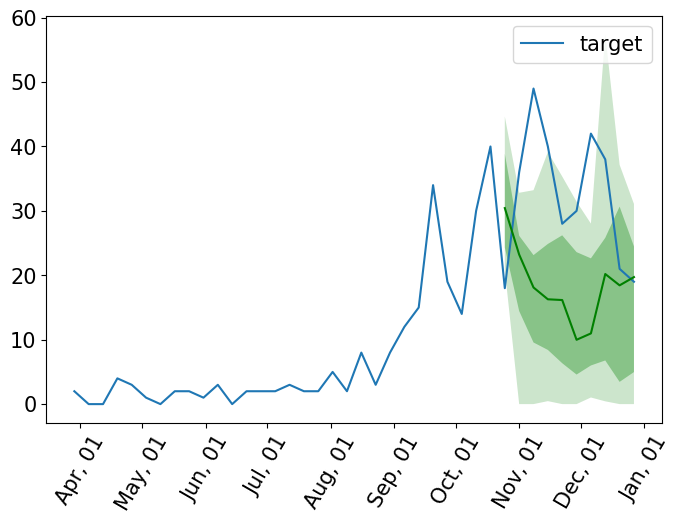

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device = torch.device('cpu'),

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [ ]:
predictor = estimator.train(training_data, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 2.36522 (best 2.36522), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 2.36522 (best 2.36522), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 1.33785 (best 1.33785), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 1.33785 (best 1.33785), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.84340 (best 0.84340), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=testing_data,
        predictor=predictor,
        num_samples=num_samples
    )

In [ ]:
forecasts = list(tqdm(forecast_it, total=len(testing_data), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
tss = list(tqdm(ts_it, total=len(testing_data), desc="Ground truth"))

Ground truth:   0%|          | 0/1 [00:00<?, ?it/s]

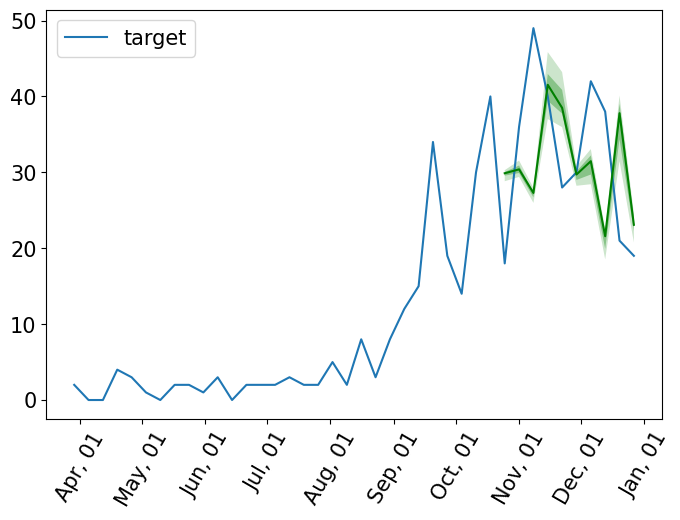

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Running evaluation: 1it [00:00,  9.26it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



In [ ]:
agg_metrics

{'MSE': 144.24581298828124,
 'abs_error': 99.34281921386719,
 'abs_target_sum': 321.0,
 'abs_target_mean': 32.1,
 'seasonal_error': 3.4146341463414633,
 'MASE': 2.909325419834682,
 'MAPE': 0.33790814876556396,
 'sMAPE': 0.3200509548187256,
 'MSIS': 89.56046177455357,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 69.74388771057129,
 'Coverage[0.1]': 0.4,
 'QuantileLoss[0.2]': 81.26332931518556,
 'Coverage[0.2]': 0.4,
 'QuantileLoss[0.3]': 89.57466964721678,
 'Coverage[0.3]': 0.4,
 'QuantileLoss[0.4]': 94.1465446472168,
 'Coverage[0.4]': 0.5,
 'QuantileLoss[0.5]': 99.34282112121582,
 'Coverage[0.5]': 0.5,
 'QuantileLoss[0.6]': 102.0896453857422,
 'Coverage[0.6]': 0.5,
 'QuantileLoss[0.7]': 102.91822013854981,
 'Coverage[0.7]': 0.6,
 'QuantileLoss[0.8]': 104.20710830688476,
 'Coverage[0.8]': 0.6,
 'QuantileLoss[0.9]': 103.39037284851074,
 'Coverage[0.9]': 0.6,
 'RMSE': 12.010237840620862,
 'NRMSE': 0.37415071154582125,
 'ND': 0.30947918758214077,
 'wQuantileLoss[0.1]': 0.2172706